# CUBE LOVE DATA REDUCTION
This his how you make love to your cube:

let's start by uploading some useful libraries

In [128]:
#!/usr/bin/env python

import pyfits
import math
from subprocess import *
from string import split
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors
from sys import argv
from scipy.ndimage.filters import convolve1d
import scipy.signal
from pylab import contour,cm,clabel
import Image
from mirpy import miriad
import os,sys
import shutil
from matplotlib.colors import LogNorm
import aplpy
from astropy import wcs
from mpl_toolkits.axes_grid1 import make_axes_locatable



Let's specify the input directory and inputfile

    - rootdir = root directory where is the inputfile  
    - input_file

- outputdirectories:

    - root_cube=cubes.fits files
    - root_mask=masks.fits files
    - root_images=2dimages.fits files
    - root_figures= \*.pdf images


+ ** these need to exist already in your working directory **

In [129]:
rootdir='/Users/maccagni/Documents/PhD/PKS1718/data/'

input_file=rootdir+'combinOB13.fits'

root_cube=rootdir+'cubes/'
root_mask=rootdir+'masks/'
root_images=rootdir+'images/'
root_figures=rootdir+'figures/'

Define some important constants

- C
- wavelength of the line for velocity transformations
- systemic velocity of the galaxy


In [130]:
C=2.99792458E8

#LAMBDAS
#s(1)
s1_0=2.12183e-6 #m
co=2.23282e-6 #m

#Systemic velocity
vel_sys=4394 #km/s

**Up to here to load always!!!!! **

*************************************************************

# Stellar continuum subtraction

Define the main parameters:

- Output file names

  - Cubes
     - stellar continuum : out_stars
     - continuum subtracted: out_starsub
     - smoothed median subtrated : out_nh
     - hanned median subtracted : out_h
     - mask for the line emission regions : mask_file
     

In [131]:
out_starsub=root_cube+'starsub.fits'
out_stars=root_cube+'stars.fits'

out_nh=root_cube+'nh.fits'
out_h=root_cube+'h.fits'

mask_file=root_mask+'H2_mask.fits'


- Constants
    
    - Edges of the cube
    - Cutoff values
    - Hanning number of channels
    - Convolution beam in arcsecons : cube and masks


In [132]:
#Spectral limits
z_low=100
z_up=2000

# EDGES of the Field of VIEW 
x_low=12
y_low=12

x_up=64
y_up=64

#cutoff value for the mask 
value=3

#hanning width
delta_vel=7 # number of channels

#spatial convolution gaussian
sigma=300./3600.  #in degrees #parameter for the emission cubes
sigma_masch=200./3600.  #in degrees   #parameter for the mask


- Functions

  - stellar subtraction

  - median subtraction

  - hanning

  - convolution
  
  - median edges definition
  
  - making masks

In [133]:
def stellar_template(masDat,copDat,data):

    avSpec_left = np.zeros(zlen)
    spec_cont=np.zeros([zlen,ylen,xlen]) 
    numSpecs_left = 0.0

    for i in range(x_low,x_up) :
        for j in range(y_low,y_up) :
            if (masDat[j,i] <= 0.01) :
                spec = data[:,j,i]
                s = spec[z_low:z_up].sum()
                avSpec_left[z_low:z_up] = avSpec_left[z_low:z_up]+spec[z_low:z_up]*s*s
                numSpecs_left += s*s
    
    avSpec_left = avSpec_left/numSpecs_left
    
    for i in range(x_low,x_up) :
        for j in range(y_low,y_up) :
            spec = data[:,j,i]
            s = spec[z_low:z_up].sum()
            ss = avSpec_left[z_low:z_up].sum()
            copDat[z_low:z_up,j,i] = data[z_low:z_up,j,i] - avSpec_left[z_low:z_up]*s/ss
            spec_cont[z_low:z_up,j,i]=avSpec_left[z_low:z_up]*s/ss

            
    #writing outputs        

    pyfits.writeto(out_starsub, copDat[:,:,:], head.copy(), clobber = True)    
    pyfits.writeto(out_starsub, spec_cont[:,:,:], head.copy(), clobber = True)            
            
    return copDat,avSpec_left

def median_mine(copDat,z_giu_l,z_su_r,a_l,a_r,b_l,b_r):

    
    copDat_medsub = np.zeros([zlen,ylen,xlen])
    rig = np.zeros([zlen])
    
    copDat_down=copDat[a_l:a_r,:,:]
    copDat_up=copDat[b_l:b_r,:,:]
    
    x_down=a_l+((a_r-a_l)/2.)
    x_upp=b_l+((b_r-b_l)/2.)
    
    for j in xrange(x_low,x_up) :
        for i in xrange(y_low,y_up) :
            med_down= np.median(copDat_down[:,i,j])
            med_up= np.median(copDat_up[:,i,j])
          
            for k in xrange(z_giu_l,z_su_r):

                med_line=float(k-x_down)/float(x_upp-x_down)*(med_up-med_down)+med_down
                rig[k]=med_line
        
            copDat[z_giu_l:z_su_r,i,j] = -rig[z_giu_l:z_su_r] +copDat[z_giu_l:z_su_r,i,j]
 
    return copDat

def hanning_mine(inputt,delta_vel):
                
        func_y=np.hanning(delta_vel)
        func_y/=np.sum(func_y)
        
        for i in range(x_low,x_up) :
            for j in range(y_low,y_up) :     
                inputt[z_low:z_up,j,i]=np.convolve(inputt[z_low:z_up,j,i],func_y,mode='same') 
        
        return inputt

def convolution(inputt,sigma,z_l_low,z_l_up):
     
        mu=0.0
        x=np.linspace(-1,1,21)
        arg=-((x-mu)*(x-mu))/(2*sigma*sigma)
        gauss_ra=1./(np.sqrt(2*np.pi)*sigma)*np.exp(arg)       

 
        
        kernel = gauss_ra.reshape(21, 1) * gauss_ra.reshape(1, 21)               
        kernel /= kernel.sum()

        inputta=np.zeros([inputt.shape[0],inputt.shape[1],inputt.shape[2]])
        
        for k in xrange(z_l_low,z_l_up):
            inputta[k,:,:] = scipy.signal.convolve2d(inputt[k,:,:], kernel, mode='same')
        
        return inputta

def subfirst(copDat,masDat,data):


    stellar_template(masDat,copDat,data)


    #median method : S(3) line

    z_giu_l3=z_low
    z_su_r3=600

    a_l=120
    a_r=210
    b_l=250
    b_r=400
    
    copDat=median_mine(copDat,z_giu_l3,z_su_r3,a_l,a_r,b_l,b_r)

    #median method : S(1) line
    
    z_giu_l1=z_su_r3
    z_su_r1=1040

    a_l=z_su_r3
    a_r=895
    b_l=932
    b_r=z_su_r1
    copDat=median_mine(copDat,z_giu_l1,z_su_r1,a_l,a_r,b_l,b_r)

    
    #median method : other  line 

    z_giu_br=z_su_r1
    z_su_br=1260

    a_l=z_su_r1
    a_r=1084
    b_l=1100
    b_r=z_su_br 
     
    copDat=median_mine(copDat,z_giu_br,z_su_br,a_l,a_r,b_l,b_r)
    
    
    #median method around the other lines

    z_giu_o=z_su_br
    z_su_o=z_up

    a_l=z_su_br
    a_r=1300
    b_l=1536
    b_r=1860 
     
    copDat=median_mine(copDat,z_giu_o,z_su_o,a_l,a_r,b_l,b_r)
    
    #convolution

    copDat=convolution(copDat,sigma,z_low,z_up) 
    pyfits.writeto(out_nh, copDat[:,:,:], head.copy(), clobber = True)

    #hanning
  
    copDat=hanning_mine(copDat,delta_vel)   
    pyfits.writeto(out_h, copDat[:,:,:], head.copy(), clobber = True)


    return copDat

def maskk(infiled,value):

    def convolution2d(inputt,sigma):
        
        mu=0.0
        x=np.linspace(-1,1,21)
        arg=-((x-mu)*(x-mu))/(2*sigma*sigma)
        gauss_ra=1./(np.sqrt(2*np.pi)*sigma)*np.exp(arg)       
        
        kernel = gauss_ra.reshape(21, 1) * gauss_ra.reshape(1, 21)               
        kernel /= kernel.sum()
        
        inputt[:,:] = scipy.signal.convolve2d(inputt[:,:], kernel, mode='same')       
        
        return inputt
    
    #S(1) line # because I mask where there is NO H2 1-0 S(1) line emission
    z_l_low=899
    z_l_up=932
    
    #edges for the noise estimation needed to set the cutoff
    x_nl=16
    x_nr=36
    y_nd=50
    y_nu=60
    
    #make the mask
    mask=np.zeros([infiled.shape[0],infiled.shape[1],infiled.shape[2]])
    mask2d=np.zeros([infiled.shape[1],infiled.shape[2]])
    n=0
    for k in xrange (z_l_low,z_l_up):
        noise=np.std(infiled[k,y_nd:y_nu,x_nl:x_nr])
        values=value*noise/1.
        n+=1
        for j in xrange (y_low,y_up):
            for i in xrange (x_low,x_up):
                if infiled[k,j,i]>values:
                    mask[k,j,i]=1.
                else:
                    mask[k,j,i]=0.0
        mask2d+=mask[k,:,:]
     
    mask_smooth2d=np.zeros([infiled.shape[1],infiled.shape[2]])
    mask_smooth2d=convolution2d(mask2d,sigma_masch)
    
    
    return mask_smooth2d

MAIN of the stellar continuum pipeline

In [134]:
##### MAIN MAIN MAIN

print '*********************'
print 'Start preparing cubes'

f=pyfits.open(input_file)
head=f[0].header
data=f[0].data

mas = pyfits.open(mask_file)
masDat = mas[0].data

xlen = data.shape[2]
ylen = data.shape[1]
zlen = data.shape[0]

#set some arrays
spec_medio= np.zeros(zlen)
copDat = np.zeros([zlen,ylen,xlen])
copCont = np.zeros([zlen,ylen,xlen])

#set the spectral band
#wave = (np.linspace(1,data.shape[0],data.shape[0])-head['CRPIX3'])* head['CDELT3'] + head['CRVAL3']
# in frequency
#wave_freq=np.array([])
#wave_freq=C/(wave*1e-6)

#iterative masking and continuum subtracting
copDat=subfirst(copDat,masDat,data)



masDat_new2d=maskk(copDat,value)

copDat = np.zeros([zlen,ylen,xlen])
copDat=subfirst(copDat,masDat_new2d,data)

print 'END of preparing cubes'
print '*********************\n'


*********************
Start preparing cubes
END of preparing cubes
*********************



# Moment maps production

Produce Intensity and Velocity field of the H2 1-0 S(1) line


** Moment 0 maps are produced in RELATIVE FLUX [ x 10^12 erg s^-1 cm^-2] **

** Moment 1 maps are in km s^-1 relative to the systemic velocity = vel_sys in fundamental parameters **

SINFONI input maps: W m^-2

Conversion to erg s^-1 cm^-2: x 10^7 x 10^-4


*****************


Define the main parameters:

-Input files
    
    - final data cube = out_nh in "Stellar continuum subtraction" 
    
    - cube of the stellar continuum = out_stars in "Stellar continuum subtraction"
    
    - hanned final data cube = out_h - to create the masks for the moment 0 and 1 maps
    



In [135]:
in_nh=root_cube+'nh.fits'       #final data cube
in_stars=root_cube+'stars.fits' #same as out_stars in stellar continuum
in_h=root_cube+'h.fits'         #hanned final data cube

 - Output file names
   - name of the line
   - Cubes
   - Images
   - Figures

In [136]:
linename='s1'

#cubes
out_int_cu=root_cube+'int_cube_'+linename+'.fits'

#images
out_int_im=root_images+'int_im_'+linename+'.fits'
out_vel_im=root_images+'vel_im_'+linename+'.fits'

#figures
out_int_fig=root_figures+'int_'+linename+'.pdf'
out_vel_fig=root_figures+'vel_'+linename+'.pdf'

#masks
out_vel_mask=root_mask+'vel_mask_'+linename+'.fits'


- Constants
    - location of the line in channels (edges of the integration)
    - edges of the field of view, to estimate the noise, and to build the moment maps
    - parameters to smooth the cube and the masks for moment 0 and 1 maps and the mask
    - signal cutoff to produce the maps (in rms noise)
    - sigma contour leves for plotting
    - direction of the continuum of the radio jets 
        - array extension in x,y pixel coordinates
        - position angle

In [137]:
#S(1) line
z_l_low=901
z_l_up=930

#edges for the noise estimation within the field of view in channels
x_nl=16
x_nr=36
y_nd=50
y_nu=60

z_l=899
z_u=932

#spatial convolution gaussian
sigma_vel=300./3600.  #in degrees
sigma_int=300./3600.  #in degrees
sigma_masch=200./3600.  #in degrees

#rms noise cutoff 
value_vel=2.5
val_int=2.5

#sigma values on the noise for the contours
val_sig_neg=[-1.5,-2.5]
val_sig_int=[1.5,3,5,7,9,12]

#direction of the continuum of the radio jets
x_mid=41
y_mid=39
x_loww=36.5
x_upp=45.5
pa_cont_ALL=42 

- Determine the wavelength range reading the header of the cube

In [138]:
f=pyfits.open(in_h)
in_mask=f[0].data
headd=f[0].header
#set the spectral band
wave = (np.linspace(1,in_mask.shape[0],in_mask.shape[0])-headd['CRPIX3'])* headd['CDELT3'] + headd['CRVAL3']
# in frequency
wave_freq=np.array([])
wave_freq=C/(wave*1e-6)

In [139]:
def vel_vec(wave,s_line):
    vel=(C*(wave*1e-6-s_line)/s_line)*1e-3
    vel=vel-vel_sys
    
    return vel

def intensity(infiled,mask,wave):

    print 'INTENSITY'

    intens=np.zeros([infiled.shape[1],infiled.shape[2]])
    intensnew=np.zeros([infiled.shape[1],infiled.shape[2]])
   

    diff=0.0 
    noise_int=0.0
    n=0.0
    for k in xrange(z_l,z_u):
        noise_int+=(np.std(infiled[k,y_nd:y_nu,x_nl:x_nr]))*(np.std(infiled[k,y_nd:y_nu,x_nl:x_nr]))
        diff+=wave[k+1]-wave[k]
        n+=1.
        for j in xrange(y_low,y_up):
            for i in xrange(x_low,x_up):             
                if mask[k,j,i]>=0.001:
                    intens[j,i]=intens[j,i]+infiled[k,j,i]

    
    ##set the right units:
    # from W/m^2 * 1e7*1e-4 = erg/s cm^-2  * 1e8 to normalize
    
    diff_av=abs(diff/n)
    intens=np.multiply(intens,diff_av)
 
    noise_int=np.sqrt(noise_int)*diff_av
    val_int=np.multiply(val_sig_int,noise_int)

    for k in xrange(z_l_low,z_l_up): 
        for j in xrange(y_low,y_up):
            for i in xrange(x_low,x_up):     
                if  intens[j,i]>=val_int[0]:
                    intensnew[j,i]=intens[j,i]
 

    intens=intensnew*1e7/1e-16
    val_int=val_int*1e7/1e-16

    #write output image .figs
    pyfits.writeto(out_int_im,intens, head.copy(), clobber = True) 
    #write output cube .figs
    pyfits.writeto(out_int_cu,infiled[z_l:z_u,:,:], head.copy(), clobber = True) 
    
    
    #determine the direction of the radio jets of the continuum
    x3=np.linspace(x_loww,x_upp,100)
    m=np.tan(math.radians(pa_cont_ALL))
    y3=m*(x3-x_mid)+y_mid
    
    
    ##MAKE PLOT .pdf
    #PLOT

    #open HANNED cube for aplpy
    #f=pyfits.open(in_h)
    #headd=f[0].header

    #set initial parameters of the plot
    f = plt.figure(figsize=(8,8))
    params = {'legend.fontsize': 14,
           'axes.linewidth':1,
           'lines.linewidth':5,
           'legend.linewidth': 4,
           'xtick.labelsize':20,
           'ytick.labelsize':20,
           'xlabel.fontsize':20,
           'ylabel.fontsize':20,
           'text.usetex': True,
           'text.latex.unicode' : True }
    rc('font',**{'family':'serif','serif':['serif']})

    plt.rcParams.update(params)

    f = aplpy.FITSFigure(in_nh,dimensions=[0,1],slices=[0],tight_layout=True)
    f.add_grid()
    f.recenter(float(headd['CRVAL1'])+0.00027,float(headd['CRVAL2'])-0.00007,width=math.radians(6.1/60.),
               height=math.radians(6.2/60.))
    
    f.axis_labels.set_font(size=20,weight=300, \
                         stretch='ultra-condensed',\
                         style='normal', variant='normal')
    
    f.ticks.set_xspacing(0.0015)  # degrees
    f.tick_labels.set_font(size=20,weight=300, \
                         style='normal',stretch='ultra-condensed')


    #plot the direction of the radio jets
    plt.plot(x3,y3,color='green',lw=4,ls='--')
    
    #plot the moment zero map
    im = plt.imshow(intens[x_low:x_up,y_low:y_up], cmap='gist_heat_r',origin='lower',interpolation='spline36',
                    vmin=np.min(intens[x_low:x_up,y_low:y_up]),
                    vmax=np.max(intens[x_low:x_up,y_low:y_up]),
                    extent=(x_low,x_up,y_low,y_up))
    #and its contours                   
    cset = contour(intens[x_low:x_up,y_low:y_up],val_int,origin='lower',colors='gray',linewidths=1,ls=':',
                   extent=(x_low,x_up,y_low,y_up))
    
    #plot contours of isophotes
    
    #open stars cube to plot the isophotes
    f=pyfits.open(in_stars)
    
    #determine noise of the cube for contour levels
    stars=f[0].data 
    stars_image=np.zeros([ylen,xlen])
    mean_value=0.0
    
    for i in xrange(700,750):
        stars_image+=stars[i,:,:]
        mean_value+=np.std(stars[i,51:61,15:34])
        
    #set contour levels
    value=[mean_value,5.*mean_value,7.*mean_value,9.*mean_value,15.*mean_value]
    #plot contours
    cset = contour(stars_image[x_low:x_up,y_low:y_up],value,origin='lower',colors='black',linewidths=1,ls=':',
                   extent=(x_low,x_up,y_low,y_up))

    
    cbar=plt.colorbar(im,spacing='uniform')
    cbar.ax.tick_params(direction='out')
    cbar.ax.get_yaxis().labelpad = 2
    cbar.ax.tick_params(labelsize=20) 
    cbar.ax.set_ylabel(r'Relative Intensity', rotation=90,fontsize=20)
    
  
    #save the image
    f=plt.savefig(out_int_fig,clobber='yes')
    
    
    return val_int

def velocity(infiled,mask,vel,val):
    
    print 'VELOCITY'

    #define vectors for integral
    velox=np.zeros([infiled.shape[1],infiled.shape[2]])
    velox_sum=np.zeros([infiled.shape[1],infiled.shape[2]])
    veloc=np.zeros([infiled.shape[0],infiled.shape[1],infiled.shape[2]])

    #determine the moment 1 map
    print val
    diff=0.0
    for k in xrange(z_l,z_u):
        diff=vel[k+1]-vel[k]
        noise=np.std(infiled[k,y_nd:y_nu,x_nl:x_nr])
        values=val_vel[0]*noise     
        for j in xrange(y_low,y_up):
            for i in xrange(x_low,x_up):     
                if  mask[j,i]>=val[0] and infiled[k,j,i]>=values:
                    velox[j,i]=velox[j,i]+infiled[k,j,i]*vel[k]*diff
                    velox_sum[j,i]=velox_sum[j,i]+infiled[k,j,i]*diff
                    veloc[k,j,i]=infiled[k,j,i]*vel[k]*diff
                    

    # setright units
    velox_tot=np.divide(velox,velox_sum)

    #relative to the systemic velocity
    velox_tot=velox_tot-vel_sys

    #determine the direction of the radio jets
    x3=np.linspace(x_loww,x_upp,100)
    m=np.tan(math.radians(pa_cont_ALL))
    y3=m*(x3-x_mid)+y_mid
    
    ## Make Plot .pdf
    #PLOT

    #set the right parameters for the plot
    ff = plt.figure(figsize=(8,8))
    params = {'legend.fontsize': 14,
           'axes.linewidth':1,
           'lines.linewidth':5,
           'legend.linewidth': 4,
           'xtick.labelsize':20,
           'ytick.labelsize':20,
           'xlabel.fontsize':20,
           'ylabel.fontsize':20,
           'text.usetex': True,
           'text.latex.unicode' : True }
    rc('font',**{'family':'serif','serif':['serif']})

    plt.rcParams.update(params)


    f = aplpy.FITSFigure(in_nh,dimensions=[0,1],slices=[0],tight_layout=True)
    f.add_grid()
    f.recenter(float(headd['CRVAL1'])+0.00027,float(headd['CRVAL2'])-0.00007,width=math.radians(6.1/60.),height=math.radians(6.2/60.))

    f.axis_labels.set_font(size=20, weight=300, \
                         stretch='ultra-condensed',\
                         style='normal', variant='normal')
    
    f.ticks.set_xspacing(0.0015)  # degrees
    f.tick_labels.set_font(size=20, weight=300, \
                         style='normal',stretch='ultra-condensed')
    
    #plot the direction of the radio jet
    plt.plot(x3,y3,color='black',lw=4,ls='--')
    
    #plot the moment 1 map
    im = plt.imshow(velox_tot[x_low:x_up,y_low:y_up], cmap='nipy_spectral',interpolation='spline36',origin='lower'
                    ,vmin=-300,vmax=300,extent=(x_low,x_up,y_low,y_up))

    
    # plot the colors
    cbar=plt.colorbar(im) 
    cbar.ax.get_yaxis().labelpad = - 10
    cbar.ax.tick_params(labelsize=18) 
    cbar.ax.set_ylabel(r'km s$^{-1}$', rotation=90,fontsize=20)
    
    #draw intensity contours
    cset = contour(mask[x_low:x_up,y_low:y_up],val,origin='lower',colors='black',linewidths=1,ls=':',extent=(x_low,x_up,y_low,y_up))
    
    #save the figure
    ff=plt.savefig(out_vel_fig)
    
    #write output image
    pyfits.writeto(out_vel_im,velox_tot, head.copy(), clobber = True)     
    
    #write output mask 
    pyfits.writeto(out_vel_mask,mask, head.copy(), clobber = True)  

    return velox_tot

def mask_int(infiled,value):

    def convolution(inputt,sigma):
     
        mu=0.0
        x=np.linspace(-1,1,21)
        arg=-((x-mu)*(x-mu))/(2*sigma*sigma)
        gauss_ra=1./(np.sqrt(2*np.pi)*sigma)*np.exp(arg)       

 
        
        kernel = gauss_ra.reshape(21, 1) * gauss_ra.reshape(1, 21)               
        kernel /= kernel.sum()

        inputta=np.zeros([inputt.shape[0],inputt.shape[1],inputt.shape[2]])
        
        for k in xrange(z_l_low,z_l_up):
            inputta[k,:,:] = scipy.signal.convolve2d(inputt[k,:,:], kernel, mode='same')
        
        return inputta
    
    #S(1) line # because I mask where there is NO H2 1-0 S(1) line emission
    z_l=899
    z_up=932
    
    #edges for the noise estimation needed to set the cutoff
    
    #make the mask
    mask=np.zeros([infiled.shape[0],infiled.shape[1],infiled.shape[2]])
    n=0
    for k in xrange (z_l,z_u):
        noise=np.std(infiled[k,y_nd:y_nu,x_nl:x_nr])
        values=value*noise/1.
        n+=1
        for j in xrange (y_low,y_up):
            for i in xrange (x_low,x_up):
                if infiled[k,j,i]>values:
                    mask[k,j,i]=1.
                else:
                    mask[k,j,i]=0.0
     
    mask_smooth=np.zeros([infiled.shape[0],infiled.shape[1],infiled.shape[2]])
    mask_smooth=convolution(mask,sigma_masch)
    
    
    return mask_smooth


MAIN of the moment maps production

Populating the interactive namespace from numpy and matplotlib
(2216, 78, 75)
INTENSITY
VELOCITY

`%matplotlib` prevents importing * from pylab and numpy
/Library/Python/2.7/site-packages/IPython/kernel/__main__.py:164: RuntimeWarning: invalid value encountered in divide



[ 0.48069932  0.96139864  1.60233107  2.24326349  2.88419592  3.84559456]
NORMAL TERMINATION


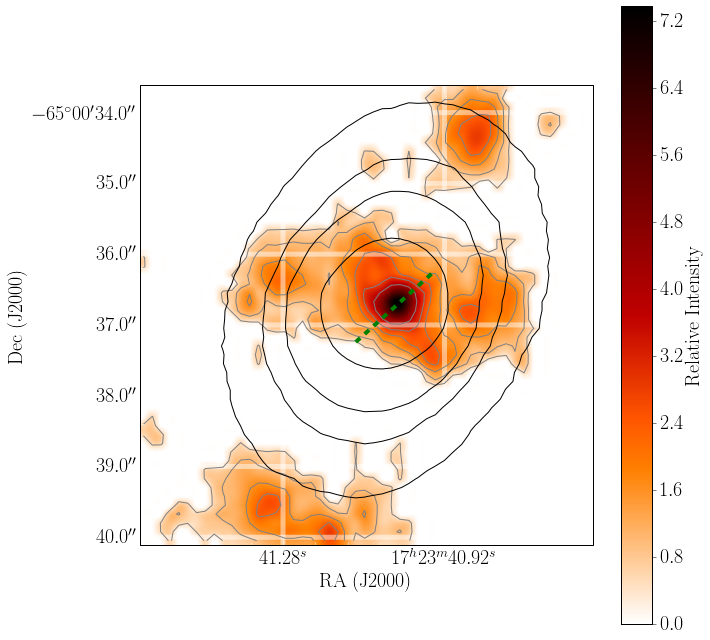

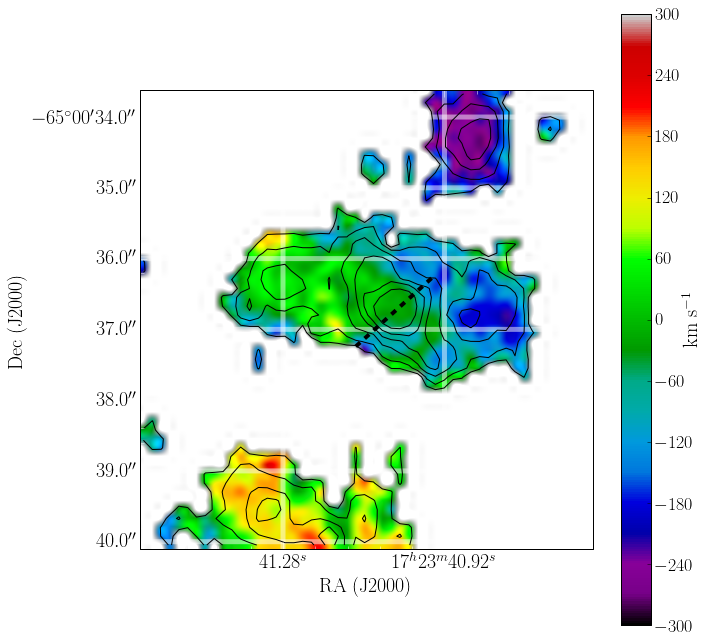

In [140]:
## MAIN for moment map production
get_ipython().magic(u'pylab inline')

#intensity
#make a mask using the hanned cube
mask=mask_int(in_mask,value_vel)
#open final cube cube
f=pyfits.open(in_nh)
infile=f[0].data
head=f[0].header
val_vel=intensity(infile,mask,wave)


#velocity
#open the intensity map to use as a mask
f=pyfits.open(out_int_im)
infiled=f[0].data

#determine the velocity of the line in km/s
vel_s1=(C*(wave*1e-6-s1_0)/s1_0)*1e-3 #!!!!!!!!!
#vel_s1=vel_vec(wave,s1_0)

cassa=velocity(infile,infiled,vel_s1,val_vel)

print 'NORMAL TERMINATION'

In [290]:
file=root_cube+'stars.fits'
f=pyfits.open(file)
stars=f[0].data    
print stars.shape


(2216, 78, 75)


In [74]:
print copDat[200:900,38:42,38:42]

[[[ 0.  0.  0.  0.]
  [ 0.  0.  0.  0.]
  [ 0.  0.  0.  0.]
  [ 0.  0.  0.  0.]]

 [[ 0.  0.  0.  0.]
  [ 0.  0.  0.  0.]
  [ 0.  0.  0.  0.]
  [ 0.  0.  0.  0.]]

 [[ 0.  0.  0.  0.]
  [ 0.  0.  0.  0.]
  [ 0.  0.  0.  0.]
  [ 0.  0.  0.  0.]]

 ..., 
 [[ 0.  0.  0.  0.]
  [ 0.  0.  0.  0.]
  [ 0.  0.  0.  0.]
  [ 0.  0.  0.  0.]]

 [[ 0.  0.  0.  0.]
  [ 0.  0.  0.  0.]
  [ 0.  0.  0.  0.]
  [ 0.  0.  0.  0.]]

 [[ 0.  0.  0.  0.]
  [ 0.  0.  0.  0.]
  [ 0.  0.  0.  0.]
  [ 0.  0.  0.  0.]]]


Populating the interactive namespace from numpy and matplotlib
[[[ 0.  0.  0.  0.]
  [ 0.  0.  0.  0.]
  [ 0.  0.  0.  0.]
  [ 0.  0.  0.  0.]]

 [[ 0.  0.  0.  0.]
  [ 0.  0.  0.  0.]
  [ 0.  0.  0.  0.]
  [ 0.  0.  0.  0.]]

 [[ 0.  0.  0.  0.]
  [ 0.  0.  0.  0.]
  [ 0.  0.  0.  0.]
  [ 0.  0.  0.  0.]]

 ..., 
 [[ 0.  0.  0.  0.]
  [ 0.  0.  0.  0.]
  [ 0.  0.  0.  0.]
  [ 0.  0.  0.  0.]]

 [[ 0.  0.  0.  0.]
  [ 0.  0.  0.  0.]
  [ 0.  0.  0.  0.]
  [ 0.  0.  0.  0.]]

 [[ 0.  0.  0.  0.]
  [ 0.  0.  0.  0.]
  [ 0.  0.  0.  0.]
  [ 0.  0.  0.  0.]]]


`%matplotlib` prevents importing * from pylab and numpy


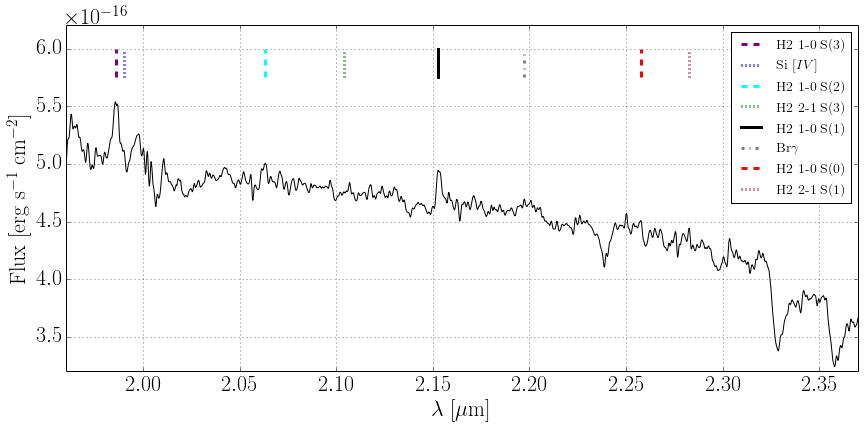

In [309]:
#SPECTRUM

get_ipython().magic(u'pylab inline')


#infiled=copDat
#open file
file=rootdir+'combinOB13.fits'
f=pyfits.open(file)
infiled=f[0].data
head=f[0].header
wave = (np.linspace(1,infiled.shape[0],infiled.shape[0])-head['CRPIX3'])* head['CDELT3'] + head['CRVAL3']
wave_freq=np.array([])
wave_freq=C/(wave*1e-6)
vel_s3=vel_vec(wave,s3_0)
vel_s1=vel_vec(wave,s1_0)
infiled=hanning_mine(infiled,9)
#infiled=subfirst(infiled)
#*** CENTRE ***#
#average spectrum
x_l_s=37
x_r_s=44
y_d_s=37
y_u_s=44
print copDat[:,38:42,38:42]
spec_cool=np.zeros([infiled.shape[0]])
n=0
#for i in xrange (x_l_s,x_r_s):
#    for j in xrange (y_0d_s,y_u_s):
for i in xrange (0,infiled.shape[0]):
    spec_cool[i]=np.mean(infiled[i,39:41,38:41])
#        n+=1.
#convert in Janksy and micro janksy
#spec_cool=np.divide(spec_cool,n)
spec_cool=np.multiply(spec_cool,wave)
#spec_cool=spec_cool*1e7*1e23*1e3
spec_cool=spec_cool*1e3

#PLOT
fig = plt.figure(figsize=(14.2,6.2))

params = {'legend.fontsize': 14,
          'axes.linewidth':1,
           'legend.linewidth': 4,
           'xtick.labelsize':22,
           'ytick.labelsize':22,
           'text.usetex': True,
           'text.latex.unicode' : True }
rc('font',**{'family':'serif','serif':['serif']})


plt.rcParams.update(params)
a = fig.add_subplot(111, autoscalex_on=True,autoscaley_on=True)
a.plot(wave[z_low:z_up],spec_cool[z_low:z_up],c='black',lw=1)
plt.ylabel('Flux [erg s$^{-1}$ cm$^{-2}$]',fontsize=22)
plt.xlabel(r'$\lambda$ [$\mu$m]',fontsize=22)
a.set_xlim([1.960,2.37])
a.set_ylim([3.2*1e-16,6.2*1e-16])

#a_y=[0,0]
#a_x=[wave[z_low],wave[z_up]]
#a.plot(a_x,a_y,lw=1,color='black')


#detected lines
#S(3)
s3_y=[5.75*1e-16,6.0*1e-16]
peak=np.argmax(spec_cool[z_3_low:z_3_up])
s3_x=[wave[z_3_low+peak],wave[z_3_low+peak]]
a.plot(s3_x,s3_y,lw=3,color='purple',label='H2 1-0 S(3)',ls='--')

#detected lines
#Si IV
siv_y=[5.75*1e-16,6.0*1e-16]
peak=np.argmax(spec_cool[z_3_up:z_3_up+10])
siv_x=[wave[z_3_up+peak],wave[z_3_up+peak]]
a.plot(siv_x,siv_y,lw=3,color='blue',label='Si $[\small IV]$',ls=':')

#S(2)
s0_l=520
s0_r=580
s3_y=[5.75*1e-16,6.0*1e-16]
peak=np.argmax(spec_cool[s0_l:s0_r])
s3_x=[wave[s0_l+peak],wave[s0_l+peak]]
a.plot(s3_x,s3_y,lw=3,color='cyan',label='H2 1-0 S(2)',ls='--')

#2-1S(3)
s0_l=700
s0_r=720
s3_y=[5.75*1e-16,6.0*1e-16]
peak=np.argmax(spec_cool[s0_l:s0_r])
s3_x=[wave[s0_l+peak],wave[s0_l+peak]]
a.plot(s3_x,s3_y,lw=3,color='green',label='H2 2-1 S(3)',ls=':')

#S(1)
s1_y=[5.75*1e-16,6.0*1e-16]
peak=np.argmax(spec_cool[z_l_low:z_l_up])
s1_x=[wave[z_l_low+peak],wave[z_l_low+peak]]
a.plot(s1_x,s1_y,lw=3,color='black',label='H2 1-0 S(1)',ls='-')

#brgamma
br_l=1078
br_r=1111

s1_y=[5.75*1e-16,6.0*1e-16]
peak=np.argmax(spec_cool[br_l:br_r])
s1_x=[wave[br_l+peak],wave[br_l+peak]]
a.plot(s1_x,s1_y,lw=3,color='grey',label='Br$\gamma$',ls='-.')


#S(0)
s0_l=1340
s0_r=1370

s1_y=[5.75*1e-16,6.0*1e-16]
peak=np.argmax(spec_cool[s0_l:s0_r])
s1_x=[wave[s0_l+peak],wave[s0_l+peak]]
a.plot(s1_x,s1_y,lw=3,color='red',label='H2 1-0 S(0)',ls='--')

#2-1S(1)
s0_l=1420
s0_r=1448

s1_y=[5.75*1e-16,6.0*1e-16]
peak=np.argmax(spec_cool[s0_l:s0_r])
s1_x=[wave[s0_l+peak],wave[s0_l+peak]]
a.plot(s1_x,s1_y,lw=3,color='brown',label='H2 2-1 S(1)',ls=':')


#a.annotate('Center 4 pixel', xy=(0.5, 0.05), xycoords='axes fraction', fontsize=16,
#                horizontalalignment='center', verticalalignment='bottom')
plt.legend()
#plt.title('Centre',fontsize=22,y=1.01)
plt.grid()
plt.show()

outfile_fig=root_figures+'spectrum_centre_withcont.pdf'
fig.savefig(outfile_fig)

Populating the interactive namespace from numpy and matplotlib
34.6159461791
[ -1.24680000e+03  -1.14295216e+03  -1.03910432e+03  -9.35256484e+02
  -8.31408646e+02  -7.27560807e+02  -6.23712969e+02  -5.19865130e+02
  -4.16017292e+02  -3.12169453e+02  -2.08321615e+02  -1.04473776e+02
  -6.25937554e-01   1.03221901e+02   2.07069740e+02   3.10917578e+02
   4.14765417e+02   5.18613255e+02   6.22461094e+02   7.26308932e+02
   8.30156771e+02   9.34004609e+02   1.03785245e+03   1.14170029e+03
   1.24554812e+03   1.34939596e+03]
redshift 242.311623253
[-12.95685848 -12.95685848]
fwzi 657.702977402


`%matplotlib` prevents importing * from pylab and numpy


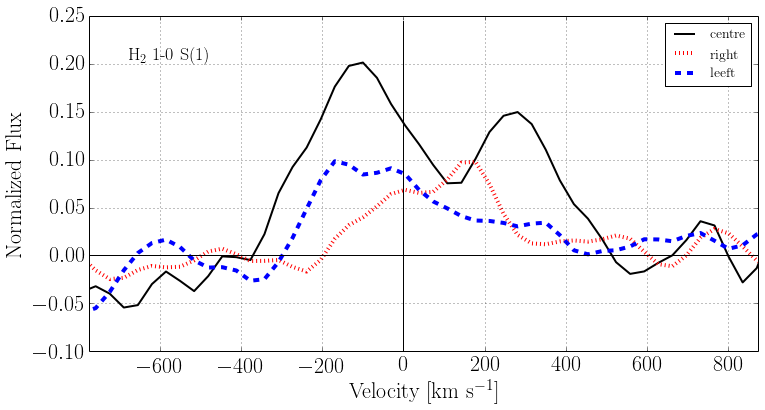

In [ ]:
#SPECTRUM
get_ipython().magic(u'pylab inline')

#S(1) line
z_l_low=899
z_l_up=932

#S(3) line
z_3_low=220
z_3_up=248

file=rootdir+'combinOB13.fits'
f=pyfits.open(file)
head=f[0].header
datat=f[0].data

datat=hanning_mine(datat,7)
#set the spectral band
wave = (np.linspace(1,datat.shape[0],datat.shape[0])-head['CRPIX3'])* head['CDELT3'] + head['CRVAL3']
# in frequency
wave_freq=np.array([])
wave_freq=C/(wave*1e-6)
vel_s1=vel_vec(wave,s1_0)

m=rootdir+'m_smooth2d.fits'
mas = pyfits.open(m)
masDat = mas[0].data

xlen = datat.shape[2]
ylen = datat.shape[1]
zlen = datat.shape[0]

copDat = np.zeros([zlen,ylen,xlen])

copDat,spec_medio1=stellar_template(x_low,x_up,y_low,y_up,masDat,copDat,datat)

x_mid=41
y_mid=39
z_l_low=z_l_low-100
z_l_up=z_l_up+100

s=np.sum(datat[z_l_low:z_l_up,y_mid,x_mid])
ss=np.sum(spec_medio1[z_l_low:z_l_up])

specsum_l = np.zeros([zlen])
specsum_r = np.zeros([zlen])
n=0.
for i in xrange(37,39):
    specsum_l[z_l_low:z_l_up]+=datat[z_l_low:z_l_up,39,i]
    n+=1.
    
specsum_l/=n

n=0.
for i in xrange(42,44):
    specsum_r[z_l_low:z_l_up]+=datat[z_l_low:z_l_up,39,i]
    n+=1.    
specsum_r/=n

spec_medio1[z_l_low:z_l_up]=spec_medio1[z_l_low:z_l_up]*s/ss

datat[z_l_low:z_l_up,y_mid,x_mid]=datat[z_l_low:z_l_up,y_mid,x_mid]-np.median(datat[z_l_low:z_l_up,y_mid,x_mid])

specsum_l[z_l_low:z_l_up]=specsum_l[z_l_low:z_l_up]-np.median(specsum_l[z_l_low:z_l_up])
specsum_r[z_l_low:z_l_up]=specsum_r[z_l_low:z_l_up]-np.median(specsum_r[z_l_low:z_l_up])


specsum_l=np.divide(specsum_l,wave_freq)
specsum_l=specsum_l*1e7*1e23*1e3
specsum_r=np.divide(specsum_r,wave_freq)
specsum_r=specsum_r*1e7*1e23*1e3

vec=np.array(datat[:,y_mid,x_mid])

datal=np.divide(vec,wave_freq)
datal=datal*1e7*1e23*1e3

diff=0.0
n=0.0
for i in xrange (z_l_low+100,z_l_up-100):
    diff+=vel_s1[i+1]-vel_s1[i]
    n+=1.
    
diff/=n
diffvec=np.arange(-1246.8,1386.8,diff*3)
print diff
print diffvec
fig = plt.figure(figsize=(12,6))
params = {'legend.fontsize': 14,
           'axes.linewidth':1,
           'lines.linewidth':5,
           'legend.linewidth': 4,
           'xtick.labelsize':22,
           'ytick.labelsize':22,
           'xlabel.fontsize':22,
           'ylabel.fontsize':22,
           'text.usetex': True,
           'text.latex.unicode' : True }
rc('font',**{'family':'serif','serif':['serif']})

plt.rcParams.update(params)

a = fig.add_subplot(111, autoscalex_on=True,autoscaley_on=True)
#a.set_xticks(diffvec,minor=True)
#a.xaxis.grid(True, which='minor')
a.plot(vel_s1[z_l_low:z_l_up],datal[z_l_low:z_l_up],c='black',lw=2,label='centre')
a.plot(vel_s1[z_l_low:z_l_up],specsum_l[z_l_low:z_l_up],c='red',lw=4,label='right',ls=':')
a.plot(vel_s1[z_l_low:z_l_up],specsum_r[z_l_low:z_l_up],c='blue',lw=4,label='leeft',ls='--')
a.set_xlim([-774,874])
#a.set_ylim([-1.5e-20,3e-20])

plt.ylabel('Normalized Flux',fontsize=22)
plt.xlabel(r'Velocity [km s$^{-1}$]',fontsize=22)

#o line
c=[-774,874]
d=[0,0]
a.plot(c,d,lw=1,c='black')


#o line
c=[-0.1,0.245]
d=[0,0]
a.plot(d,c,lw=1,c='black')

#HI rotation lines
c=[4551,4551]
d=[-1.5e-20,3.0e-20]
#a.plot(c,d,lw=1,c='grey',ls='--')

#HI rotation lines
c=[3981,3981]
d=[-1.5e-20,3.0e-20]
#a.plot(c,d,lw=1,c='grey',ls='--')

#systemic velocity line
c=[4325,4325]
d=[-1.5e-20,3.0e-20]
#a.plot(c,d,lw=1,c='grey',ls='--')
#left min centre
edge_c_l=[vel_s1[argmin(datat[903:910,y_mid,x_mid])+903],vel_s1[argmin(datat[903:910,y_mid,x_mid])+903]]
a.plot(edge_c_l,d,c='black',ls='--')

#left min centre
edge_c_r=[vel_s1[argmin(datat[925:933,y_mid,x_mid])+925],vel_s1[argmin(datat[925:933,y_mid,x_mid])+925]]
a.plot(edge_c_r,d,c='black',ls='--')

#left min left
edge_c_l=[vel_s1[argmin(specsum_r[905:910])+905],vel_s1[argmin(specsum_r[905:910])+905]]
a.plot(edge_c_l,d,c='blue',ls='--')

#left min centre
#edge_c_r=[vel_s1[argmin(specsum_l[917:933])+917],vel_s1[argmin(specsum_l[917:933])+917]]
#a.plot(edge_c_r,d,lw=1,c='blue',ls='--')

#left min left
#edge_c_l=[vel_s1[argmin(specsum_l[903:910])+903],vel_s1[argmin(specsum_l[903:910])+903]]
#a.plot(edge_c_l,d,lw=1,c='green',ls='--')

#left min rigth
edge_c_rr=[vel_s1[argmin(specsum_l[917:925])+917],vel_s1[argmin(specsum_l[917:925])+917]]
a.plot(edge_c_rr,d,lw=1,c='red',ls='--')

vel_diff=edge_c_r[0]-edge_c_rr[0]
print 'redshift '+str(vel_diff)

vel_diff=-edge_c_l[0]+edge_c_rr[0]
s=edge_c_l+vel_diff/2.
print s
print 'fwzi '+str(vel_diff)

#a.set_yticks([0.3,0.55,0.7], minor=True)
a.annotate(r'H$_2$ 1-0 S(1)', xy=(0.12, 0.85), xycoords='axes fraction', fontsize=18,
                horizontalalignment='center', verticalalignment='bottom')

plt.legend()
plt.grid()
plt.show()

fig.savefig(root_figures+'spectrum_cont.pdf',bbox_inches='tight')

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


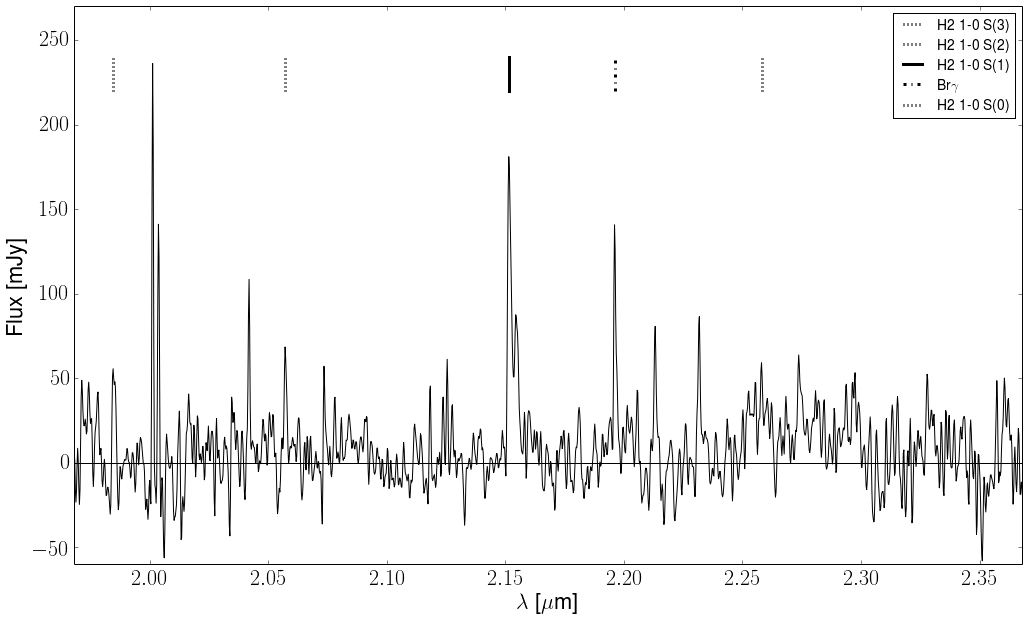

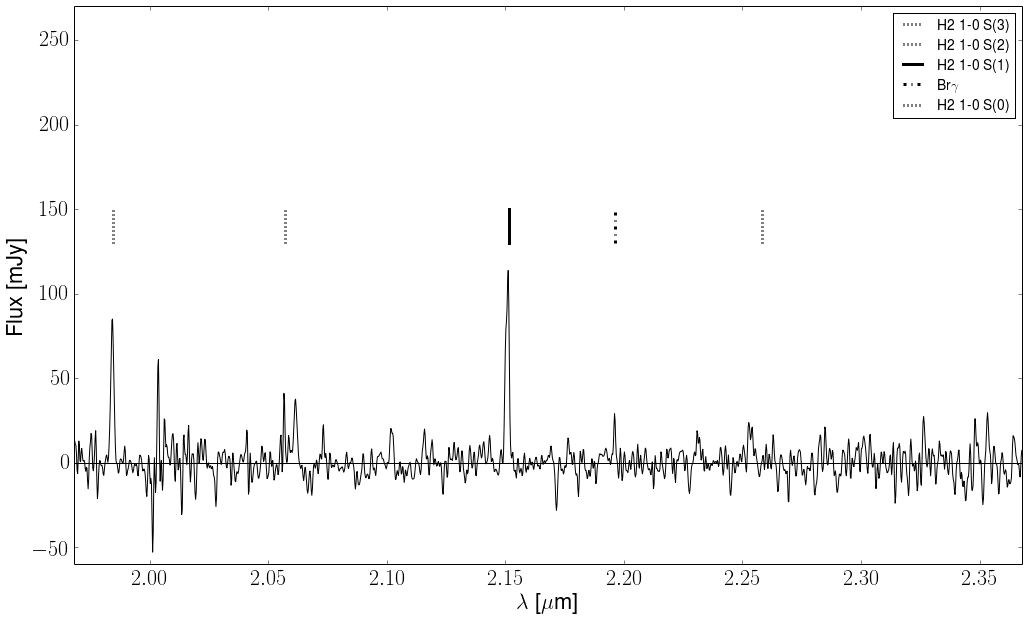

In [12]:
#SPECTRUM
get_ipython().magic(u'pylab inline')

vel_s3=vel_vec(wave,s3_0)
vel_s1=vel_vec(wave,s1_0)

#open file
file=root_cube+'h.fits'
f=pyfits.open(file)
infiled=f[0].data

#*** CENTRE ***#
#average spectrum
x_l_s=40
x_r_s=41
y_d_s=38
y_u_s=39

spec_cool=np.zeros([infiled.shape[0]])
n=0
#for i in xrange (x_l_s,x_r_s):
#    for j in xrange (y_0d_s,y_u_s):
spec_cool+=infiled[:,39,41]
#        n+=1.

#convert in Janksy and micro janksy
#spec_cool=np.divide(spec_cool,n)
spec_cool=np.divide(spec_cool,wave_freq)
spec_cool=spec_cool*1e7*1e23*1e6


#PLOT
fig = plt.figure(figsize=(17,10))

params = {'legend.fontsize': 14,
           'axes.linewidth':1,
           'lines.linewidth':5,
           'legend.linewidth': 4,
           'xtick.labelsize':22,
           'ytick.labelsize':22,
           'xlabel.fontsize':22,
           'ylabel.fontsize':22,
           'text.usetex': True,
           'text.latex.unicode' : True }
plt.rcParams.update(params)
a = fig.add_subplot(111, autoscalex_on=True,autoscaley_on=True)
a.plot(wave[z_low:z_up],spec_cool[z_low:z_up],c='black',lw=1)
plt.ylabel('Flux [mJy]',fontsize=22)
plt.xlabel(r'$\lambda$ [$\mu$m]',fontsize=22)
a.set_xlim([1.968,2.368])
a.set_ylim([-60,270])

a_y=[0,0]
a_x=[wave[z_low],wave[z_up]]
a.plot(a_x,a_y,lw=1,color='black')


#detected lines
#S(3)
s3_y=[220,240]
peak=np.argmax(spec_cool[z_3_low:z_3_up])
s3_x=[wave[z_3_low+peak],wave[z_3_low+peak]]
a.plot(s3_x,s3_y,lw=3,color='black',label='H2 1-0 S(3)',ls=':')


#S(2)
s0_l=520
s0_r=580
s3_y=[220,240]
peak=np.argmax(spec_cool[s0_l:s0_r])
s3_x=[wave[s0_l+peak],wave[s0_l+peak]]
a.plot(s3_x,s3_y,lw=3,color='black',label='H2 1-0 S(2)',ls=':')

#S(1)
s1_y=[220,240]
peak=np.argmax(spec_cool[z_l_low:z_l_up])
s1_x=[wave[z_l_low+peak],wave[z_l_low+peak]]
a.plot(s1_x,s1_y,lw=3,color='black',label='H2 1-0 S(1)',ls='-')

#brgamma
br_l=1078
br_r=1111

s1_y=[220,240]
peak=np.argmax(spec_cool[br_l:br_r])
s1_x=[wave[br_l+peak],wave[br_l+peak]]
a.plot(s1_x,s1_y,lw=3,color='black',label='Br$\gamma$',ls='-.')


#S(0)
s0_l=1300
s0_r=1350

s1_y=[220,240]
peak=np.argmax(spec_cool[s0_l:s0_r])
s1_x=[wave[s0_l+peak],wave[s0_l+peak]]
a.plot(s1_x,s1_y,lw=3,color='black',label='H2 1-0 S(0)',ls=':')


#a.annotate('Center 4 pixel', xy=(0.5, 0.05), xycoords='axes fraction', fontsize=16,
#                horizontalalignment='center', verticalalignment='bottom')
plt.legend()
#plt.title('Centre',fontsize=22,y=1.01)

plt.show()

outfile_fig=root_figures+'spectrum_centre.pdf'
fig.savefig(outfile_fig)

#*** NW corner ***#
#average spectrum
x_l_s=49
x_r_s=50
y_d_s=57
y_u_s=58

spec_cool1=np.zeros([infiled.shape[0]])
n=0
for i in xrange (x_l_s,x_r_s):
    for j in xrange (y_d_s,y_u_s):
        spec_cool1+=infiled[:,j,i]
        n+=1.

#convert in Janksy and micro janksy
spec_cool1=np.divide(spec_cool1,n)
spec_cool1=np.divide(spec_cool1,wave_freq)
spec_cool1=spec_cool1*1e7*1e23*1e6


#PLOT
fig = plt.figure(figsize=(17,10))



plt.rcParams.update(params)
a = fig.add_subplot(111, autoscalex_on=True,autoscaley_on=True)
a.plot(wave[z_low:z_up],spec_cool1[z_low:z_up],c='black',lw=1)
plt.ylabel('Flux [mJy]',fontsize=22)
plt.xlabel(r'$\lambda$ [$\mu$m]',fontsize=22)
a.set_xlim([1.968,2.368])
a.set_ylim([-60,270])

a_y=[0,0]
a_x=[wave[z_low],wave[z_up]]
a.plot(a_x,a_y,lw=1,color='black')


#detected lines
#S(3)
s3_y=[130,150]
peak=np.argmax(spec_cool[z_3_low:z_3_up])
s3_x=[wave[z_3_low+peak],wave[z_3_low+peak]]
a.plot(s3_x,s3_y,lw=3,color='black',label='H2 1-0 S(3)',ls=':')


#S(2)
s0_l=520
s0_r=580
s3_y=[130,150]
peak=np.argmax(spec_cool[s0_l:s0_r])
s3_x=[wave[s0_l+peak],wave[s0_l+peak]]
a.plot(s3_x,s3_y,lw=3,color='black',label='H2 1-0 S(2)',ls=':')

#S(1)
s1_y=[130,150]
peak=np.argmax(spec_cool[z_l_low:z_l_up])
s1_x=[wave[z_l_low+peak],wave[z_l_low+peak]]
a.plot(s1_x,s1_y,lw=3,color='black',label='H2 1-0 S(1)',ls='-')

#brgamma
br_l=1078
br_r=1111

s1_y=[130,150]
peak=np.argmax(spec_cool[br_l:br_r])
s1_x=[wave[br_l+peak],wave[br_l+peak]]
a.plot(s1_x,s1_y,lw=3,color='black',label='Br$\gamma$',ls='-.')


#S(0)
s0_l=1300
s0_r=1350

s1_y=[130,150]
peak=np.argmax(spec_cool[s0_l:s0_r])
s1_x=[wave[s0_l+peak],wave[s0_l+peak]]
a.plot(s1_x,s1_y,lw=3,color='black',label='H2 1-0 S(0)',ls=':')


#a.annotate('Center 4 pixel', xy=(0.5, 0.05), xycoords='axes fraction', fontsize=16,
#                horizontalalignment='center', verticalalignment='bottom')
plt.legend()
#plt.title('N-W corner',fontsize=22,y=1.01)
plt.show()

outfile_fig=root_figures+'spectrum_nw.pdf'
fig.savefig(outfile_fig)

In [11]:
#pv-plot
rootdir='/Users/maccagni/Documents/PKS1718/par_inv/'

#H2
file=root_cube+'h.fits'
f=pyfits.open(file)
infiled=f[0].data
headd=f[0].header


file=rootdir+'combinOB13.fits'
f=pyfits.open(file)

head=f[0].header
data=f[0].data
#set the spectral band
wave = (np.linspace(1,data.shape[0],data.shape[0])-head['CRPIX3'])* head['CDELT3'] + head['CRVAL3']
# in frequency
wave_freq=np.array([])
wave_freq=C/(wave*1e-6)
x_l_s=39-20
x_r_s=42+20
y_mid=39

xdim= x_r_s-x_l_s
vel=vel_vec(wave,s1_0)
xmid=(x_r_s-x_l_s)/2.
zdim=z_l_up-z_l_low

diff=0.
n=0.
for i in xrange(z_l_low,z_l_up):
    diff+=vel[i+1]-vel[i]
    n+=1.

diff=diff/n

pv = pyfits.PrimaryHDU()
head_pv=pv.header

print headd['CRVAL1']

head_pv.set('NAXIS',2,after='BITPIX')
head_pv.set('NAXIS1',xdim,after='NAXIS')
head_pv.set('NAXIS2',zdim,after='NAXIS1')
head_pv.set('CTYPE1',headd['CTYPE1'],after='NAXIS2')
head_pv.set('CRPIX1',xmid,after='CTYPE1')
head_pv.set('CRVAL1',headd['CRVAL1'],after='CRPIX1')
head_pv.set('CDELT1',headd['CDELT1'],after='CRVAL1')
head_pv.set('CTYPE2','VEL-OPT',after='CDELT1')
head_pv.set('CRPIX2',1,after='CTYPE2')
head_pv.set('CRVAL2',vel[z_l_low],after='CRPIX2')
head_pv.set('CDELT2',diff,after='CRVAL2')

#s(1)
pv_plot=infiled[z_l_low:z_l_up,y_mid,x_l_s:x_r_s]
pv_plot=convolution2d(pv_plot,300./3600.)
outfile=root_images+'pv_plot_s1.fits'
pyfits.writeto(outfile,pv_plot, head_pv.copy(), clobber = True)     


x_l_sn=25
x_r_sn=42
z_l_downn=20
z_l_upn=31

pv_plot_noise=pv_plot[z_l_downn:z_l_upn,x_l_sn:x_r_sn]
noise_pv=np.std(pv_plot_noise)
val_pv=np.multiply(val_sig,noise_pv)
val_pv_neg=np.multiply(val_sig_neg,noise_pv)

#set the spectral band



params = {'legend.fontsize': 14,
           'axes.linewidth':1,
           'lines.linewidth':5,
           'legend.linewidth': 4,
           'xticks.labelsize':1,
           'xtick.labelsize':22,
           'ytick.labelsize':22,
           'xlabel.fontsize':22,
           'ylabel.fontsize':22,
           'text.usetex': True,
           'text.latex.unicode' : True }
plt.rcParams.update(params)
ff= plt.figure(figsize=(12,6),tight_layout=True)
#SET TICK LABELS
ax = axes([0,0,1,1], frameon=True)
ax.set_xlim(-1000,1000)
ax.set_ylim(vel[z_l_low],vel[z_l_up])
labels = [item.get_text() for item in ax.get_xticklabels()]
#arcseconds
print labels
labels=[-2.4,-1.2,0,1.2,2.4]
ax.set_xticklabels(labels)



labels = [item.get_text() for item in ax.get_yticklabels()]
#print len(labels)
labels=['' '',-400,-200,0,200,400,600]

ax.set_yticklabels(labels)


a=[-1000,1000]
b=[0,0]
plt.plot(a,b,lw=1,c='black',ls='--')
a=[0,0]
b=[vel[z_l_low],vel[z_l_up]]
plt.plot(a,b,lw=1,c='black',ls='--')
im=plt.imshow(pv_plot, cmap='gist_heat_r',origin='lower',interpolation='spline36',vmin=0.027e-21,vmax=3.20e-20,
              extent=[-1000,1000,vel[z_l_low],vel[z_l_up]])
#tl = im.axes.get_xaxis()
#print t1
#axis = axes.get_xaxis
#im.set_data(new_data)
#axis.set_ticks([10,20,30,x,t])
#axis.set_ticklabels(["p", "u", "z", "z", "i"])
#a#xes.draw_artist(im)
#axes.draw_artist(axis)



#im.axes.get_xaxis().set_visible(False)
cset = contour(pv_plot,val_pv,linewidths=2,origin='lower',colors='gray',extent=[-1000,1000,vel[z_l_low],vel[z_l_up]])
cset = contour(pv_plot,val_pv_neg,linewidths=2,origin='lower',colors='gray',
               extent=[-1000,1000,vel[z_l_low],vel[z_l_up]],ls='--')


plt.xlabel(r'Angular offset [arcseconds]',fontsize=22)

plt.ylabel(r'Velocity [km s$^{-1}$]',fontsize=22)


plt.savefig(root_figures+'pv_plot_as.pdf',bbox_inches='tight')



#arcseconds
print labels
labels=[-700,-350,0,350,700]
#ax.xaxis.set_tick_params(width=1)
ax.set_xticklabels(labels)
plt.xlabel(r'Radial offset [pc]',fontsize=22)


#plt.show()
plt.savefig(root_figures+'pv_plot_r.pdf',bbox_inches='tight')


260.920954187


NameError: name 'convolution2d' is not defined

`%matplotlib` prevents importing * from pylab and numpy
/Library/Python/2.7/site-packages/pyfits/file.py:339: UserWarning: Overwriting existing file 'masks/m_cube_int3.fits'.
  warnings.warn("Overwriting existing file %r." % self.name)
/Library/Python/2.7/site-packages/pyfits/file.py:339: UserWarning: Overwriting existing file 'masks/m_2dint3.fits'.
  warnings.warn("Overwriting existing file %r." % self.name)
/Library/Python/2.7/site-packages/pyfits/file.py:339: UserWarning: Overwriting existing file 'masks/m_cube_smoothint3.fits'.
  warnings.warn("Overwriting existing file %r." % self.name)


Populating the interactive namespace from numpy and matplotlib
INTENSITY

/Library/Python/2.7/site-packages/pyfits/file.py:339: UserWarning: Overwriting existing file 'masks/m_smooth2dint3.fits'.
  warnings.warn("Overwriting existing file %r." % self.name)
/Library/Python/2.7/site-packages/pyfits/file.py:339: UserWarning: Overwriting existing file 'images/intensitys3.fits'.
  warnings.warn("Overwriting existing file %r." % self.name)



VELOCITY
[  4.71287351e-24   9.42574702e-24   1.57095784e-23   2.19934097e-23
   2.82772410e-23   3.77029881e-23]

/Library/Python/2.7/site-packages/IPython/kernel/__main__.py:32: RuntimeWarning: invalid value encountered in divide
/Library/Python/2.7/site-packages/pyfits/file.py:339: UserWarning: Overwriting existing file 'images/velocitys3.fits'.
  warnings.warn("Overwriting existing file %r." % self.name)



NORMAL TERMINATION


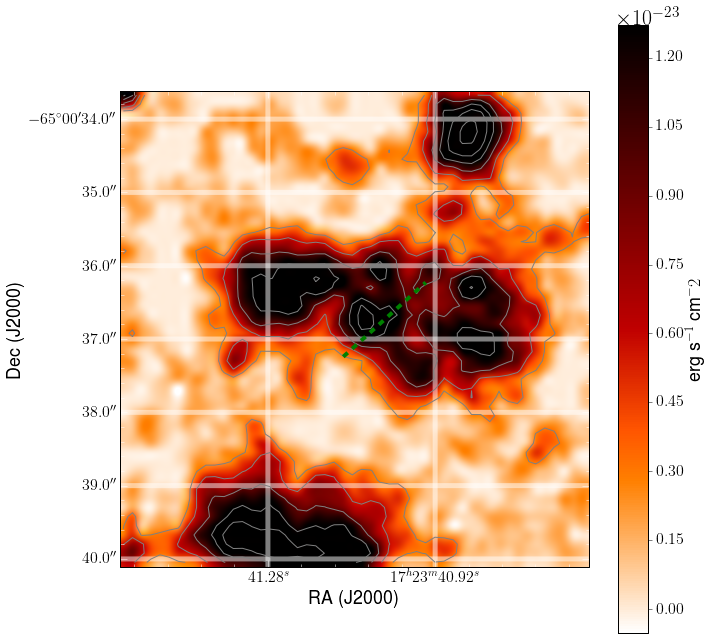

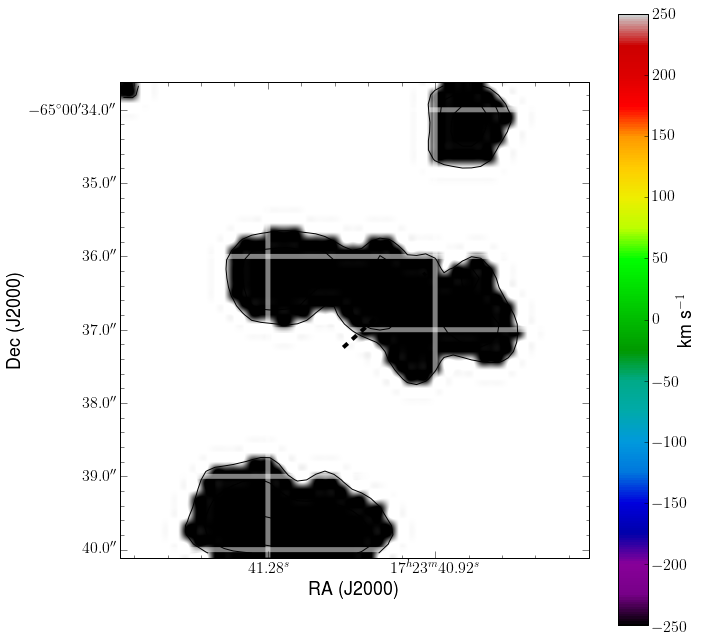

In [237]:
#DATA ANALYSIS S1
get_ipython().magic(u'pylab inline')   


linename='s3'
cicle='int3'

file=rootdir+'nh.fits'
f=pyfits.open(file)
infile=f[0].data


#intensity
mask,mask2d=maskk(infile,z_3_low,z_3_up,cicle,value_vel)
massa=intensity(infile,mask,wave,z_3_low,z_3_up,linename)


#velocity
file=rootdir+'intensita_s3.fits'
f=pyfits.open(file)
infiled=f[0].data

vel_s3=vel_vec(wave,s3_0)
cassa=velocity(infile,infiled,vel_s3,val_vel,z_3_low,z_3_up,linename)


print 'NORMAL TERMINATION'

In [ ]:
### HI STUFF ###
#read the HI spectrum
filename='hi_spectrum.txt'
hi_data=np.genfromtxt(filename,unpack=True,dtype='double')
vel_hi=hi_data[0,:]
flux_hi=hi_data[1,:]

#convert it into velocity wrt systemic
vel_hi=vel_hi*1e-3
vel_hi=vel_hi-vel_sys
#convert flux in mJy
flux_hi=flux_hi*1e3
#read the HI spectrum
filename='hi_emission.txt'
hi_data=np.genfromtxt(filename,unpack=True,dtype='double')
vel_hie=hi_data[0,:]
flux_hie=hi_data[1,:]
#convert it into velocity wrt systemic
vel_hie=vel_hie-vel_sys
#convert flux in mJy
flux_hie=flux_hie*1e3

a.plot(vel_hi,flux_hi,c='blue',lw=2,label='HI absorption')
a.plot(vel_hie,flux_hie,c='cyan',lw=2,label='HI emission')
#a.plot(vel_hiem,flux_hiem,c='black',label='HI emission')


In [ ]:
#### OLD PLOTS ####
plt.rcParams.update(params)
a = fig.add_subplot(111, autoscalex_on=True,autoscaley_on=True)
#a.set_xlim([-300,600])
a.plot(vel_s1[z_l_low:z_l_up],spec_cool[z_l_low:z_l_up],c='red',lw=3,label='H2 1-0 S(1)')
a.plot(vel_s3[z_3_low:z_3_up],spec_cool[z_3_low:z_3_up],c='blue',lw=3,label='H2 1-0 S(3)')
plt.ylabel('Flux [mJy]',fontsize=22)
plt.xlabel('Velocity [km/s]',fontsize=22)
plt.legend()
plt.show()

In [ ]:
file=rootdir+'combinOB13.fits'
f=pyfits.open(file)
head=f[0].header
datat=f[0].data

datat=hanning_mine(datat,vel_width)

z_3_low=z_3_low-20
z_3_up=z_3_up+100

s=np.sum(datat[z_3_low:z_3_up,y_mid,x_mid])
ss=np.sum(spec_medio1[z_3_low:z_3_up])

specsum_l = np.zeros([zlen])
specsum_r = np.zeros([zlen])
n=0.
for i in xrange(37,39):
    specsum_l[z_3_low:z_3_up]+=datat[z_3_low:z_3_up,39,i]
    n+=1.
    
specsum_l/=n

n=0.
for i in xrange(42,44):
    specsum_r[z_3_low:z_3_up]+=datat[z_3_low:z_3_up,39,i]
    n+=1.
    
specsum_r/=n

spec_medio1[z_3_low:z_3_up]=spec_medio1[z_3_low:z_3_up]*s/ss

datat[z_3_low:z_3_up,y_mid,x_mid]=datat[z_3_low:z_3_up,y_mid,x_mid]-np.median(datat[z_3_low:z_3_up,y_mid,x_mid])

specsum_l[z_3_low:z_3_up]=specsum_l[z_3_low:z_3_up]-np.median(specsum_l[z_3_low:z_3_up])
specsum_r[z_3_low:z_3_up]=specsum_r[z_3_low:z_3_up]-np.median(specsum_r[z_3_low:z_3_up])

vel_s3=vel_vec(wave,s3_0)


fig = plt.figure(figsize=(15,6))
plt.rcParams.update(params)
a = fig.add_subplot(111, autoscalex_on=True,autoscaley_on=True)
a.plot(vel_s3[z_3_low:z_3_up],datat[z_3_low:z_3_up,y_mid,x_mid],c='red',lw=2,label='(0,0)')
a.plot(vel_s3[z_3_low:z_3_up],specsum_l[z_3_low:z_3_up],c='blue',lw=2,label='(-2,0)')
a.plot(vel_s3[z_3_low:z_3_up],specsum_r[z_3_low:z_3_up],c='green',lw=2,label='(2,0)')
#a.plot(wave[z_l_low:z_l_up],spec_medio1[z_l_low:z_l_up],c='blue',lw=2)
#a.plot(wave[z_l_low:z_l_up],spec_clean[z_l_low:z_l_up],c='black',lw=2,label='- stellar spectrum * 3')
#a.set_xlim([-800,800])
a.set_xlim([-1000,1000])




plt.ylabel('Flux [mJy]')
plt.xlabel(r'Wavelength [$\mu$m]')
plt.legend()

a.annotate('H2 1-0 S(3)', xy=(0.8, 0.02), xycoords='axes fraction', fontsize=20,
                horizontalalignment='center', verticalalignment='bottom')

plt.show()


spec_medio=spec_medio1
spec_medio=np.divide(spec_medio,wave_freq)
spec_medio=spec_medio*1e7*1e23*1e6
